In [ ]:
from main import *

from glob import glob

import seaborn as sns

import pandas as pd


import os
import string

from matplotlib.colors import ListedColormap

In [2]:
folder = 'sulov_folder'
files = glob(folder + '/BIN-*points.tif')
files

names = [os.path.basename(f)[:-11] for f in files]
names

n = len(names)
n

4

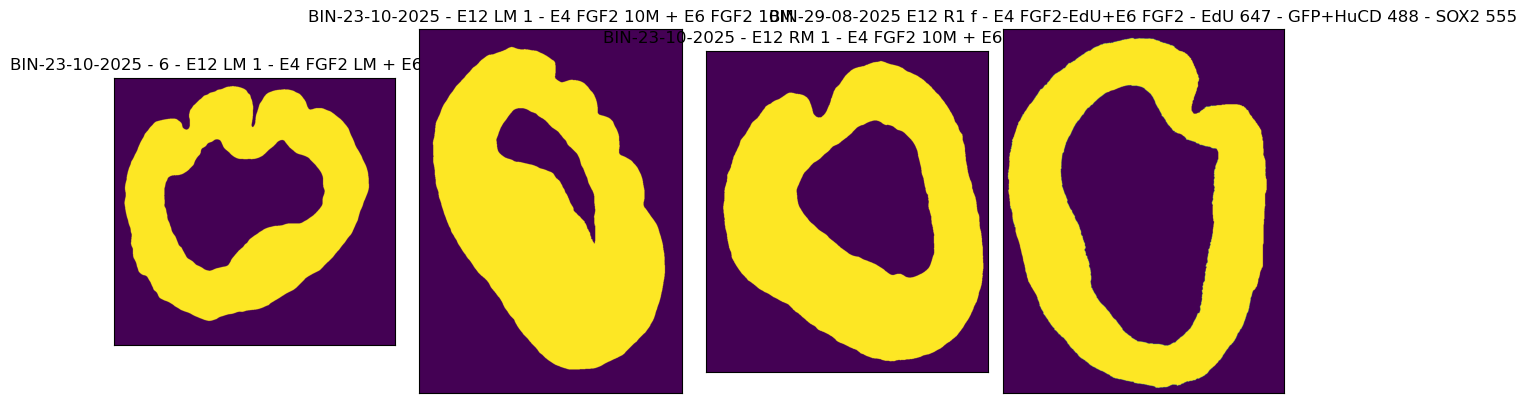

In [3]:
fig, axs = plt.subplots(1, n, figsize = (3*n,4))

for i, name in enumerate(names):

    donut, res = get_picture2D(f'{folder}/{name}.tif')

    axs[i].set_title(name)
    axs[i].imshow(donut)



for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()


In [ ]:
df = pd.DataFrame()

pics = []


for i, name in enumerate(names):
    # if i != 2:
    #     continue
    print(name)

    donut, res = get_picture2D(f'{folder}/{name}.tif')
    ref_points, _ = get_picture2D(f'{folder}/{name}_points.tif')

    res = tuple(r_comp*16 for r_comp in res)

    current_df, donut = thick_analysis(donut, ref_points, res)
    current_df['brain'] = name
    
    if len(df) == 0:
        df = current_df
    else:
        df = pd.concat([df, current_df], ignore_index=True)
    
    pics.append(donut)

    print()


BIN-23-10-2025 - 6 - E12 LM 1 - E4 FGF2 LM + E6 FGF2 LM
smoothing factor = 14.22


 17%|█▋        | 302/1731 [00:07<00:33, 42.54it/s]

In [ ]:
letters = list(string.ascii_uppercase)

brain_name_map = {b_full_name: letters[i] for i, b_full_name in enumerate(df['brain'].unique())}

df['nickname'] = df['brain'].map(brain_name_map)

brain_name_map

{'BIN-23-10-2025 - 6 - E12 LM 1 - E4 FGF2 LM + E6 FGF2 LM': 'A',
 'BIN-23-10-2025 - E12 LM 1 - E4 FGF2 10M + E6 FGF2 10M': 'B',
 'BIN-23-10-2025 - E12 RM 1 - E4 FGF2 10M + E6 FGF2 10M': 'C',
 'BIN-29-08-2025 E12 R1 f - E4 FGF2-EdU+E6 FGF2 - EdU 647 - GFP+HuCD 488 - SOX2 555': 'D'}

In [ ]:
df.head()

,norm,dist,quadrant,p_in,p_out,brain,nickname
0,0.000000,264.605415,1,"(467, 883)","(500, 1058)",BIN-23-10-2025 - 6 - E12 LM 1 - E4 FGF2 LM + E...,A
1,0.001001,264.790649,1,"(465, 882)","(496, 1060)",BIN-23-10-2025 - 6 - E12 LM 1 - E4 FGF2 LM + E...,A
2,0.002002,265.149131,1,"(463, 882)","(493, 1061)",BIN-23-10-2025 - 6 - E12 LM 1 - E4 FGF2 LM + E...,A
3,0.003003,265.658276,1,"(461, 882)","(489, 1062)",BIN-23-10-2025 - 6 - E12 LM 1 - E4 FGF2 LM + E...,A
4,0.004004,266.287437,1,"(458, 881)","(485, 1064)",BIN-23-10-2025 - 6 - E12 LM 1 - E4 FGF2 LM + E...,A


In [ ]:
quad_loc = df['quadrant'].diff()
quad_loc[0] = 1
quad_loc

quad_ind = quad_loc[quad_loc != 0].index

quad_df = df.loc[quad_ind]

quad_df

,norm,dist,quadrant,p_in,p_out,brain,nickname
0,0.000000,264.605415,1,"(467, 883)","(500, 1058)",BIN-23-10-2025 - 6 - E12 LM 1 - E4 FGF2 LM + E...,A
215,0.215215,257.691801,2,"(269, 700)","(137, 601)",BIN-23-10-2025 - 6 - E12 LM 1 - E4 FGF2 LM + E...,A
529,0.529530,235.500899,3,"(515, 215)","(505, 52)",BIN-23-10-2025 - 6 - E12 LM 1 - E4 FGF2 LM + E...,A
750,0.750751,287.947294,4,"(809, 411)","(1001, 460)",BIN-23-10-2025 - 6 - E12 LM 1 - E4 FGF2 LM + E...,A
1000,0.000000,212.120119,1,"(408, 514)","(373, 650)",BIN-23-10-2025 - E12 LM 1 - E4 FGF2 10M + E6 F...,B
1155,0.155155,308.602726,2,"(275, 303)","(112, 438)",BIN-23-10-2025 - E12 LM 1 - E4 FGF2 10M + E6 F...,B
1363,0.363363,303.000920,3,"(393, 260)","(422, 52)",BIN-23-10-2025 - E12 LM 1 - E4 FGF2 10M + E6 F...,B
1866,0.866867,305.918508,4,"(659, 567)","(614, 756)",BIN-23-10-2025 - E12 LM 1 - E4 FGF2 10M + E6 F...,B
2000,0.000000,233.071165,1,"(377, 745)","(353, 904)",BIN-23-10-2025 - E12 RM 1 - E4 FGF2 10M + E6 F...,C
2184,0.184184,238.620324,2,"(252, 570)","(139, 454)",BIN-23-10-2025 - E12 RM 1 - E4 FGF2 10M + E6 F...,C


(0.0, 981.9713866479929)

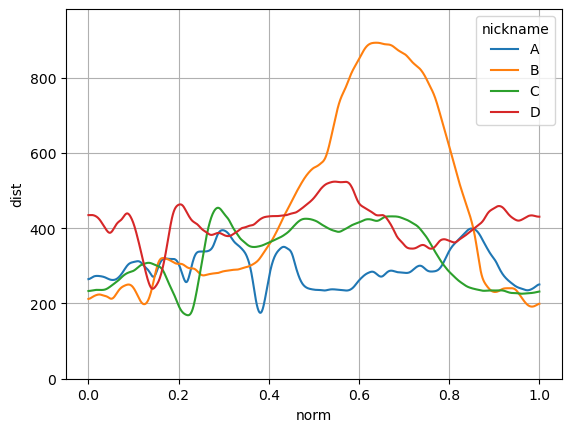

In [ ]:
sns.lineplot(data=df, x='norm', y='dist', hue='nickname')

palette = sns.color_palette('deep', df['nickname'].nunique())
color_map = dict(zip(df['nickname'].unique(), palette))
# plt.vlines(quad_df['norm'], ymin=0, ymax=df['dist'].max()*1.1, colors=quad_df['nickname'].map(color_map))

plt.grid()
plt.ylim(0, df['dist'].max()*1.1)

In [ ]:
colors = ['#ba274a', '#FE7F2D', '#FFC72E', '#43CBA7', '#299337']
quad_colors = ListedColormap(colors, name='quad_colors')

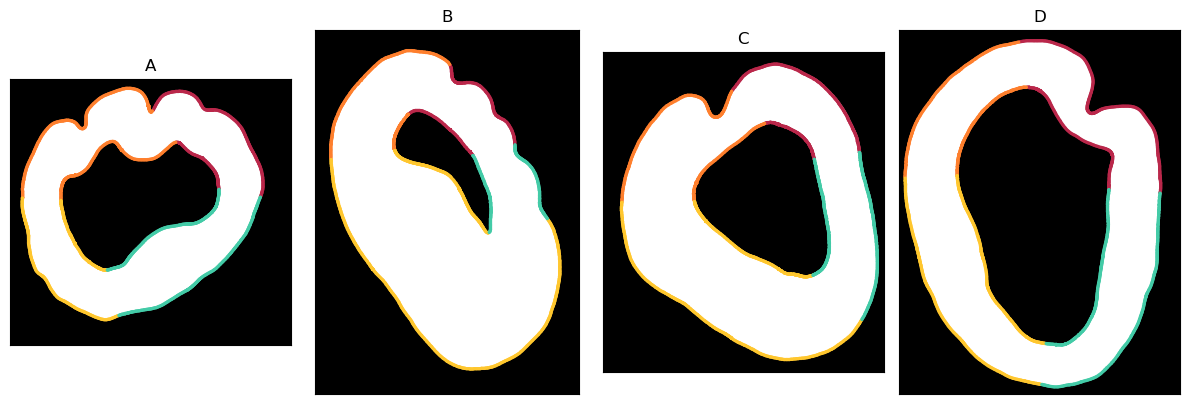

In [ ]:
fig, axs = plt.subplots(1, n, figsize = (3*n,4))

s=2


for i, name in enumerate(names):

    axs[i].set_title(letters[i])
    axs[i].imshow(pics[i], cmap='gray')

    current_df = df.loc[df['brain'] == name]

    quad_n = len(current_df['quadrant'].unique())
    cmap=ListedColormap(colors[:quad_n], name='quad_colors')

    out_df = current_df.dropna(subset=['p_out'])
    p_out = out_df['p_out']
    xs = [p[0] for p in p_out]
    ys = [p[1] for p in p_out]
    axs[i].scatter(ys, xs, c = out_df['quadrant'], s = s, cmap=cmap)


    in_df = current_df.dropna(subset=['p_in'])
    p_in = in_df['p_in']
    xs = [p[0] for p in p_in]
    ys = [p[1] for p in p_in]
    axs[i].scatter(ys, xs, c = in_df['quadrant'], s = s, cmap=cmap)


for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])


plt.tight_layout()
plt.savefig(f'{folder}/quadrants.png', dpi=300, bbox_inches='tight')
plt.show()

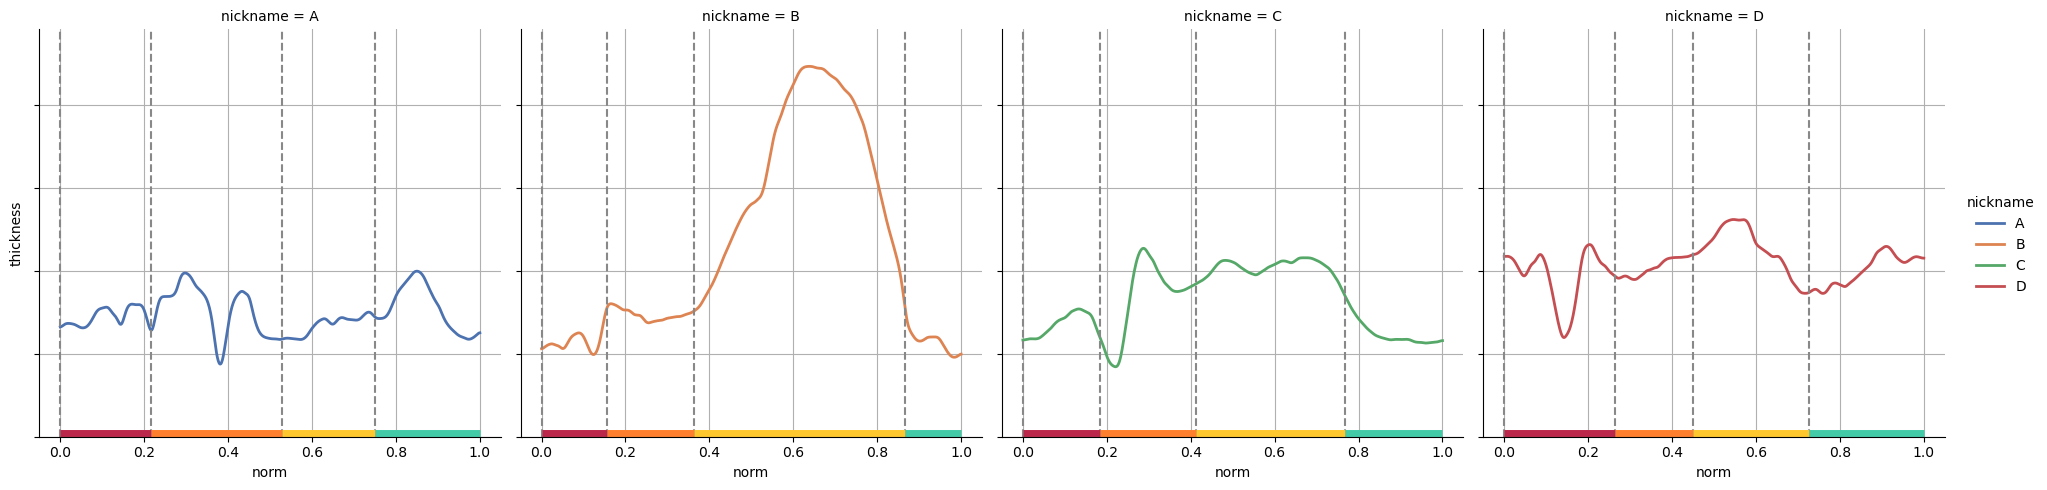

In [ ]:
g = sns.relplot(
    data=df,
    x='norm', y='dist',
    hue='nickname',
    col='nickname',
    kind='line',
    palette='deep',
    linewidth=2,
    col_wrap=4  # adjust layout
)

for nick, ax in g.axes_dict.items():
    subset = quad_df[quad_df['nickname'] == nick]
    ax.vlines(
        subset['norm'],
        ymin=0,
        ymax=df['dist'].max()*1.1,
        # colors=color_map[nick],
        colors='#888888',
        linestyles='--'
    )

    quad_points = list(subset['norm']) + [1]
    quad_n = len(subset['norm'])
    for i in range(quad_n):
        ax.hlines(
            10,
            xmin=quad_points[i],
            xmax=quad_points[i+1],
            colors = colors[i],
            linewidth = 5
        )

    ax.grid()
    ax.set_ylim(0, df['dist'].max()*1.1)
    ax.set_ylabel('thickness')

    ax.set_yticklabels([])

plt.savefig(f'{folder}/profiles.png', dpi=300, bbox_inches='tight')
    

In [ ]:
print(quad_points)

[0.0, 0.26326326326326327, 0.45045045045045046, 0.7267267267267267, 1]


In [ ]:
import glasbey

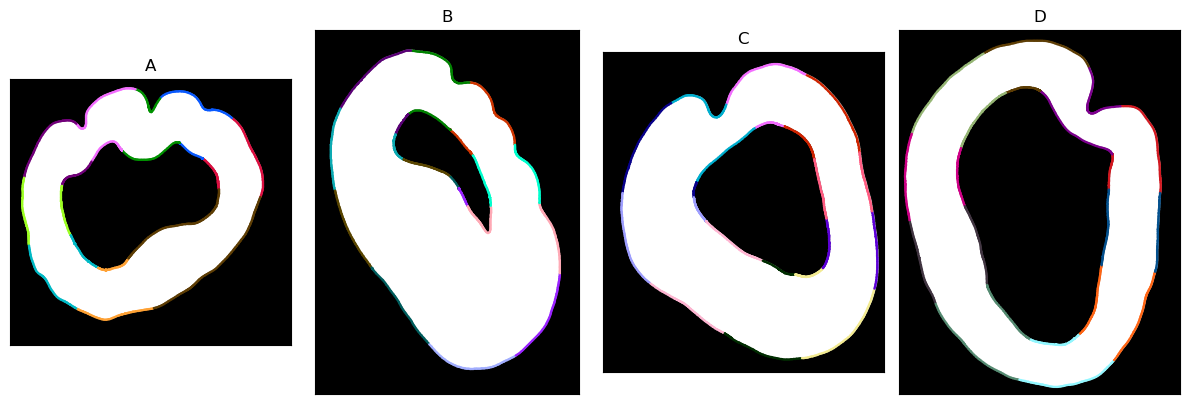

In [ ]:
fig, axs = plt.subplots(1, n, figsize = (3*n,4))

s=0.5
w = 100



for i, name in enumerate(names):


    axs[i].set_title(letters[i])
    axs[i].imshow(pics[i], cmap='gray')

    current_df = df.loc[df['brain'] == name]

    n_colors = max(current_df.index // w)
    palette = glasbey.create_palette(palette_size=n_colors)
    cmap = ListedColormap(palette)

    out_df = current_df.dropna(subset=['p_out'])
    p_out = out_df['p_out']
    xs = [p[0] for p in p_out]
    ys = [p[1] for p in p_out]
    axs[i].scatter(ys, xs, s = s, c=out_df.index // w, cmap = cmap)


    in_df = current_df.dropna(subset=['p_in'])
    p_in = in_df['p_in']
    xs = [p[0] for p in p_in]
    ys = [p[1] for p in p_in]
    axs[i].scatter(ys, xs, s = s, c=in_df.index // w, cmap = cmap)

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

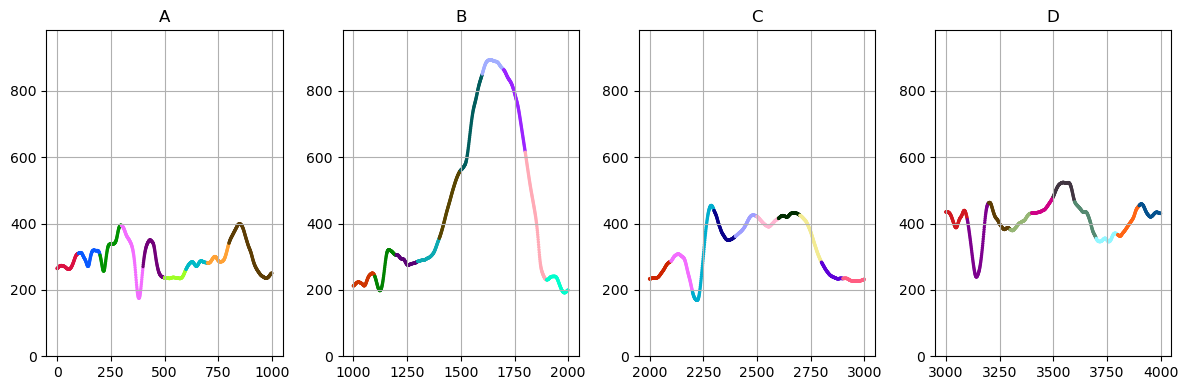

In [ ]:
fig, axs = plt.subplots(1, n, figsize = (3*n,4))

s=2

for i, name in enumerate(names):

    axs[i].set_title(letters[i])

    current_df = df.loc[df['brain'] == name]


    n_colors = max(current_df.index // w)
    palette = glasbey.create_palette(palette_size=n_colors)
    cmap = ListedColormap(palette)

    axs[i].scatter(current_df.index, current_df['dist'], s = s, c=current_df.index // w, cmap = cmap)




for ax in axs:
    ax.set_ylim(0, df['dist'].max()*1.1)
    ax.grid(True)


plt.tight_layout()
plt.show()